# Planning Notebook

In [33]:
import math
import unittest
import numpy as np
from itertools import product
import tqdm
from tqdm import tqdm_notebook
import copy
import pickle

# import gtsam
import gtsam
from gtsam import *
from gtsam.utils.test_case import GtsamTestCase

# import gtbook
import gtbook
from gtbook.display import *
from gtbook.discrete import *

# import local package
import gtsam_planner
from gtsam_planner import *

# import parser
import SASParser
from SASParser import SAS, Operator

variables = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, variables)

import graphviz
class show(graphviz.Source):
    """ Display an object with a dot method as a graph."""

    def __init__(self, obj):
        """Construct from object with 'dot' method."""
        # This small class takes an object, calls its dot function, and uses the
        # resulting string to initialize a graphviz.Source instance. This in turn
        # has a _repr_mimebundle_ method, which then renders it in the notebook.
        super().__init__(obj.dot())

In [34]:
class SASToGTSAM():
    def __init__(self, sas):
        self.sas = sas
        self.init = sas.initial_state
        self.goal = sas.goal
        self.vars = self.sas.variables
        self.ops = self.sas.operators
        self.mutex_groups = self.sas.mutex_group
        # self.ops_names = ["null"]
        self.ops_names = []
        for op in self.ops:
            self.ops_names.append(op.name)
    
    def generate_state(self, timestep):
        state = []
        for var, val in self.vars.items():
            state_var = variables.discrete(str(var)+"_"+str(timestep), val)
            state.append(state_var)
        return state
    
    def generate_operator_key(self, timestep):
        op_var = variables.discrete("op_"+str(timestep), self.ops_names)
        return op_var
    
    def generate_initial_factor(self, initial_state):
        keys = gtsam.DiscreteKeys()
        for key in initial_state:
            keys.push_back(key)
        init_values = list(self.init.values())
        init_f = gtsam_planner.MultiValueConstraint(keys, init_values)
        return init_f

    def generate_goal_factor(self, goal_state):
        state = list(self.vars.keys())
        keys = gtsam.DiscreteKeys()
        vals = []
        for goal_var, goal_val in self.goal.items():
            keys.push_back(goal_state[state.index(goal_var)])
            vals.append(goal_val)
        goal_f = gtsam_planner.MultiValueConstraint(keys, vals)
        return goal_f
    
    def generate_op_null(self, state_t, state_tp, operator):
        state = list(self.vars.keys())
        multi_keys = gtsam.DiscreteKeys()
        vals = []
        state_t_taken = []
        for pre_var, pre_val in operator.precondition.items():
            key = state_t[state.index(pre_var)]
            state_t_taken.append(key)
            if pre_val == -1:
                continue
            multi_keys.push_back(state_t[state.index(pre_var)])
            vals.append(pre_val)
        
        state_tp_taken = []
        for eff_var, eff_val in operator.effect.items():
            key = state_tp[state.index(eff_var)]
            state_tp_taken.append(key)
            if eff_val == -1:
                continue
            multi_keys.push_back(key)
            vals.append(eff_val)
        
        assert (len(state_t_taken) + len(state_tp_taken)) % 2 == 0
        null_keys = gtsam.DiscreteKeys()
        for var_t in state_t:
            if var_t not in state_t_taken:
                null_keys.push_back(var_t)
        for var_tp in state_tp:
            if var_tp not in state_tp_taken:
                null_keys.push_back(var_tp)

        # total_keys = gtsam.DiscreteKeys()
        # for key in state_t + state_tp:
        #     total_keys.push_back(key)
        op_f = gtsam_planner.MultiValueConstraint(multi_keys, vals)
        null_f = gtsam_planner.NullConstraint(null_keys)
        # op = gtsam_planner.OperatorConstraint(multi_keys, vals, null_keys, total_keys)
        return op_f, null_f
    
    def generate_null_constraint(self, state_t, state_tp):
        """
        true if state_t and state_tp is same
        false otherwise
        """
        keys = gtsam.DiscreteKeys()
        for key in (state_t+state_tp):
            keys.push_back(key)
        null_constraint = gtsam_planner.NullOperatorConstraint(keys)
        return null_constraint        

    def generate_mutex_factor(self, state_t):
        state = list(self.vars.keys())
        mutex_variables = []
        mutex_values = []
        
        for mutex_group in self.mutex_groups:
            var_group = []
            val_group = []
            for var, val in mutex_group:
                state_var = state_t[state.index(var)]
                var_group.append(state_var)
                val_group.append(val)
            mutex_variables.append(var_group)
            mutex_values.append(val_group)
        
        factors = []
        for mutex_var, mutex_val in zip(mutex_variables, mutex_values):
            keys = gtsam.DiscreteKeys()
            for var in mutex_var:
                keys.push_back(var)
            mutex = gtsam_planner.MutexConstraint(keys, mutex_val)
            factors.append(mutex)
        return factors
    
    def generate_op_factor(self, state_t, state_tp, op_key):
        op_consts = []
        null_consts = []
        for op in self.ops:
            op_const, null_const = self.generate_op_null(state_t, state_tp, op)
            op_consts.append(op_const)
            null_consts.append(null_const)

        keys_set = set()
        keys_set.add(op_key)
        # multivalue
        for op_const in op_consts:
            keys_list = op_const.discreteKeys()
            for i in range(keys_list.size()):
                keys_set.add(keys_list.at(i))
        # null
        for null_const in null_consts:
            key_list = null_const.discreteKeys()
            # print(key_list)
            print(key_list.size())
            for i in range(key_list.size()):
                print(i)
                keys_set.add(keys_list.at(i))

        keys = gtsam.DiscreteKeys()
        for key in keys_set:
            keys.push_back(key)

        # keys = gtsam.DiscreteKeys()
        # for key in state_t + state_tp:
        #     keys.push_back(key)

        op_factor = gtsam_planner.OperatorAddConstraint(op_key, keys, op_consts, null_consts)
        return op_factor

In [35]:
sas = SAS()
sas_dir = "sas/gripper_example.sas"
sas.read_file(sas_dir)
converter = SASToGTSAM(sas)

In [36]:
# def plan(plan_length):
#     for k in range(2, plan_length):
#         print(k)
#         states = []
#         mutex_factors = []
#         op_factors = []

#         for i in range(k):
#             # generate state
#             state_t = converter.generate_state(i)
#             states.append(state_t)
#             # generate mutex factor for the state
#             mutex_factor_t = converter.generate_mutex_factor(state_t)
#             mutex_factors.append(mutex_factor_t)
#         for j in range(len(states)-1):
#             op_key = converter.generate_operator_key(j)
#             op_factor = converter.generate_op_factor(states[j], states[j+1], op_key)
#             op_factors.append(op_factor)
#         initial_factor = converter.generate_initial_factor(states[0])
#         goal_factor = converter.generate_goal_factor(states[-1])

#         graph = gtsam.DiscreteFactorGraph()
#         for m_factor in mutex_factors:
#             for f in m_factor:
#                 graph.push_back(f)

#         graph.push_back(goal_factor)
#         graph.push_back(initial_factor)

#         for op_factor in op_factors:
#             graph.push_back(op_factor)

#         val = graph.optimize()
#         if graph(val) == 0.0:
#             del graph
#             continue
#         else:
#             return graph, val, k
#     return "solution not found"

In [37]:
# graph, val, k = plan(10)

In [32]:
k = 2
states = []
mutex_factors = []
op_factors = []
for i in range(k):
    state_t = converter.generate_state(i)
    states.append(state_t)
    mutex_factor_t = converter.generate_mutex_factor(state_t)
    mutex_factors.append(mutex_factor_t)
for j in range(len(states)-1):
    op_key = converter.generate_operator_key(j)
    op_factor = converter.generate_op_factor(states[j], states[j+1], op_key)
    op_factors.append(op_factor)

10


AttributeError: 'gtsam.gtsam.DiscreteKeys' object has no attribute 'begin'

In [17]:
op_consts = []
null_consts = []
for op in converter.ops:
    op_const, null_const = converter.generate_op_null(states[0], states[1], op)
    op_consts.append(op_const)
    null_consts.append(null_const)

In [18]:
initial_factor = converter.generate_initial_factor(states[0])

In [19]:
graph = gtsam.DiscreteFactorGraph()

In [20]:
initial_factor

MultiValueConstraint on 0 1 2 3 4 5 6 

In [21]:
op_consts[0]

MultiValueConstraint on 1 10 8 

In [22]:
graph.push_back(initial_factor)
graph.push_back(op_consts[0])
graph.push_back(null_consts[0])

In [23]:
graph.print()


size: 3
factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 
factor 1: MultiValueConstraint on 1 10 8 
factor 2: NullConstraint on 0 2 4 5 6 7 9 11 12 13 


In [26]:
val = graph.optimize()

In [27]:
graph(val)

0.0

In [8]:
for op_const in op_consts:
    graph.push_back(initial_factor)
    graph.push_back(op_const)
    val = graph.optimize()
    if graph(val) == 0.0:
        del graph
        continue
    else:
        break

IndexError: map::at

In [22]:
states[1]

[(7, 2), (8, 5), (9, 5), (10, 3), (11, 3), (12, 3), (13, 3)]

In [13]:
values = gtsam.DiscreteValues()
values[0] = 0
values[1] = 4
values[2] = 4
values[3] = 0
values[4] = 0
values[5] = 0
values[6] = 0

values[7] = 0
values[8] = 4
values[9] = 4
values[10] = 0
values[11] = 0
values[12] = 0
values[13] = 0

In [9]:
for op_const in op_consts:
    print(op_const(values))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [17]:
tree = op_const.toDecisionTreeFactor()

In [18]:
tree.size()

13

In [6]:
op_f = op_factors[0]
op_f_tree = op_f.toDecisionTreeFactor()

In [4]:
def plan(plan_length):
    for k in range(2, plan_length):
        states = []
        mutex_factors = []
        op_factors = []

        for i in range(k):
            # generate state
            state_t = converter.generate_state(i)
            states.append(state_t)
            # generate mutex factor for the state
            mutex_factor_t = converter.generate_mutex_factor(state_t)
            mutex_factors.append(mutex_factor_t)
        for j in range(len(states)-1):
            op_key = converter.generate_operator_key(j)
            op_factor = converter.generate_op_factor(states[j], states[j+1], op_key)
            op_factors.append(op_factor)
        initial_factor = converter.generate_initial_factor(states[0])
        goal_factor = converter.generate_goal_factor(states[-1])

        graph = gtsam.DiscreteFactorGraph()
        for m_factor in mutex_factors:
            for f in m_factor:
                graph.push_back(f)

        graph.push_back(goal_factor)
        graph.push_back(initial_factor)

        for op_factor in op_factors:
            graph.push_back(op_factor)

        val = graph.optimize()
        if graph(val) == 0.0:
            del graph
            continue
        else:
            return graph, val, k
    return graph, val, k

In [5]:
# TODO
# generate_op_constraint
# the preconditions and effect should be as is
# but it should also check that nothing else has changed --> BinarySameConstraint or NullOperatorConstraint

In [6]:
graph, val, k = plan(10)

UnboundLocalError: local variable 'graph' referenced before assignment

In [ ]:
converter.ops_names[16]

'move rooma roomb'

In [ ]:
op = converter.ops[16]

In [ ]:
op.effect

{0: 1}

In [ ]:
op.precondition

{0: 0}

In [ ]:
op.prevail

{}

In [ ]:
val

DiscreteValues{0: 0, 1: 4, 2: 4, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 4, 9: 4, 10: 1, 11: 1, 12: 1, 13: 1, 14: 16}

In [ ]:
print(graph)


size: 11
factor 0: MutexConstraint on 3 3 1 2 
factor 1: MutexConstraint on 4 4 1 2 
factor 2: MutexConstraint on 5 5 1 2 
factor 3: MutexConstraint on 6 6 1 2 
factor 4: MutexConstraint on 10 10 8 9 
factor 5: MutexConstraint on 11 11 8 9 
factor 6: MutexConstraint on 12 12 8 9 
factor 7: MutexConstraint on 13 13 8 9 
factor 8: MultiValueConstraint on 10 11 12 13 
factor 9: MultiValueConstraint on 0 1 2 3 4 5 6 
factor 10: OperatorAddConstraint on j=14



In [ ]:
tree = graph.at(10).toDecisionTreeFactor()

In [ ]:
val

DiscreteValues{0: 0, 1: 4, 2: 4, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 4, 9: 4, 10: 1, 11: 1, 12: 1, 13: 1, 14: 16}

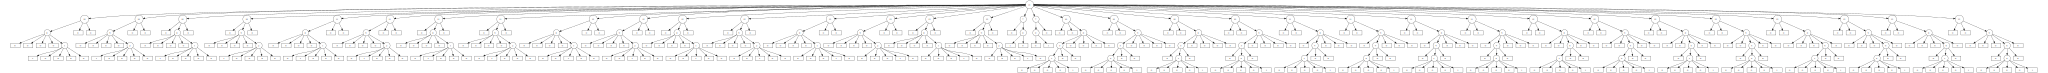

In [ ]:
show(tree)

In [ ]:
op_consts = []
for i in range(graph.size()-1, graph.size()-k, -1):
    op_consts.append(graph.at(i))
val_list = []
for op_const in reversed(op_consts):
    print(converter.ops_names[val[op_const.operatorKey()]])
# for op in val_list:
#     print(converter.ops_names[op])

move rooma roomb
